In [1]:
import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')


import os
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import cv2
from scipy.stats import uniform

from tqdm import tqdm
from glob import glob


from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking
from tensorflow.keras.utils import to_categorical



from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
#copying the pretrained models to the cache directory
cache_dir = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

#copy the Xception models
!cp ../input/keras-pretrained-models/xception* ~/.keras/models/
#show
!ls ~/.keras/models

cp: cannot stat '../input/keras-pretrained-models/xception*': No such file or directory


In [11]:
base_folder = '/content/drive/MyDrive/data'
data_folder = '/content/drive/MyDrive/data'
train_data_folder = '/content/drive/MyDrive/data/vehicles'
test_date_folder  = '/content/drive/MyDrive/data/non-vehicles'

categories = ['vehicles', 'non-vehicles']
len_categories = len(categories)

In [12]:
image_count = {}
train_data = []

for i , category in tqdm(enumerate(categories)):
    class_folder = os.path.join(data_folder, category)
    label = category
    image_count[category] = []
    
    for path in os.listdir(os.path.join(class_folder)):
        image_count[category].append(category)
        train_data.append(['{}/{}'.format(category, path), i, category])

2it [00:00, 11.48it/s]


In [13]:
#show image count
for key, value in image_count.items():
    print('{0} -> {1}'.format(key, len(value)))

vehicles -> 8792
non-vehicles -> 1810


In [14]:
df = pd.DataFrame(train_data, columns=['file', 'id', 'label'])
df.shape
df.head()

(10602, 3)

,file,id,label
0,vehicles/left (456).png,0,vehicles
1,vehicles/687.png,0,vehicles
2,vehicles/629.png,0,vehicles
3,vehicles/far (423).png,0,vehicles
4,vehicles/left (785).png,0,vehicles


In [15]:
#masking function
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    #YCrCbImage = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)
    

    # define range of red-orange color in HSV
    lower_ro = np.array([18,50,50])
    upper_ro = np.array([35,255,255])


    #lower_hsv = np.array([0,0,250])
    #upper_hsv = np.array([250,255,255])
    
    mask = cv2.inRange(image_hsv, lower_ro, upper_ro)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11,11))
    #gradient = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    return mask

#image segmentation function
def segment_image(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

#sharpen the image
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

# function to get an image
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_folder, filepath), target_size=size)
    #convert image to array
    img = image.img_to_array(img)
    return img

# New Section

In [16]:
img = read_img(df['file'][108],(255,255))
type(img)
#BGRImage = cv2.imread(img)

numpy.ndarray

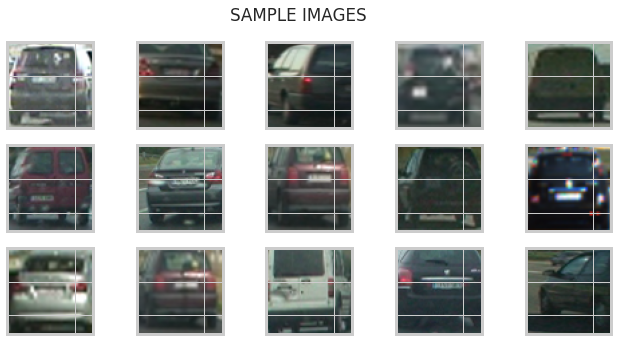

In [17]:
nb_rows = 3
nb_cols = 5
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 5));
plt.suptitle('SAMPLE IMAGES');
for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        axs[i, j].xaxis.set_ticklabels([]);
        axs[i, j].yaxis.set_ticklabels([]);
        axs[i, j].imshow((read_img(df['file'][np.random.randint(1000)], (255,255)))/255.);
plt.show();

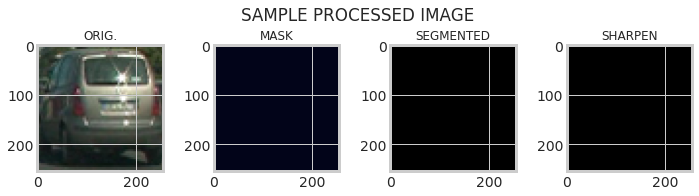

In [18]:
#get an image
img = read_img(df['file'][108],(255,255))
#mask
image_mask = create_mask_for_plant(img)
#segmentation
image_segmented = segment_image(img)
#morph

#sharpen the image
image_sharpen = sharpen_image(image_segmented)

fig, ax = plt.subplots(1, 4, figsize=(10, 5));
plt.suptitle('SAMPLE PROCESSED IMAGE', x=0.5, y=0.8)
plt.tight_layout(1)

ax[0].set_title('ORIG.', fontsize=12)
ax[1].set_title('MASK', fontsize=12)
ax[2].set_title('SEGMENTED', fontsize=12)
ax[3].set_title('SHARPEN', fontsize=12)


ax[0].imshow(img/255);
ax[1].imshow(image_mask);
ax[2].imshow(image_segmented);
ax[3].imshow(image_sharpen);

In [19]:
df

,file,id,label
0,vehicles/left (456).png,0,vehicles
1,vehicles/687.png,0,vehicles
2,vehicles/629.png,0,vehicles
3,vehicles/far (423).png,0,vehicles
4,vehicles/left (785).png,0,vehicles
...,...,...,...
10597,non-vehicles/extra4952.png,1,non-vehicles
10598,non-vehicles/extra5244.png,1,non-vehicles
10599,non-vehicles/extra5727.png,1,non-vehicles
10600,non-vehicles/extra5320.png,1,non-vehicles


In [26]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/data'):
    for filename in filenames:
        pass

In [30]:
categories = {'non-vehicles': 0,'vehicles': 1 }
imagePath = []
labels = []
classLabel = ' '
for dirname, _, filenames in os.walk('/content/drive/MyDrive/data'):
    print(dirname)
    if(dirname.split('/')[-1] != 'data'):
        classLabel = dirname.split('/')[-1]
    for filename in filenames:
        imagePath.append(dirname + '/' + filename)
        labels.append(categories[classLabel])

/content/drive/MyDrive/data


KeyError: ignored

In [28]:
shuffeledData = df.sample(frac=1).reset_index()
shuffeledData

,index,file,id,label
0,2918,vehicles/far (391).png,0,vehicles
1,812,vehicles/right (559).png,0,vehicles
2,261,vehicles/far (39).png,0,vehicles
3,1496,vehicles/5854.png,0,vehicles
4,8856,non-vehicles/extra5091.png,1,non-vehicles
...,...,...,...,...
10597,921,vehicles/right (528).png,0,vehicles
10598,664,vehicles/right (298).png,0,vehicles
10599,6312,vehicles/1772.png,0,vehicles
10600,5858,vehicles/3768.png,0,vehicles


In [23]:
from skimage.transform import resize
images = []
labels = shuffeledData['label']
for image in shuffeledData['file']:
    resizedImage = resize(image,(32,32,3))
    images.append(resizedImage)
images = np.array(images)
images = images / 255 # normalize the images


AttributeError: ignored

In [ ]:
INPUT_SIZE=255

##preprocess the input
X_train = np.zeros((len(df), INPUT_SIZE, INPUT_SIZE, df.shape[1]), dtype='float')
for i, file in tqdm(enumerate(df['file'])):
    #read image
    img = read_img(file,(INPUT_SIZE,INPUT_SIZE))
    #masking and segmentation
    image_segmented = segment_image(img)
    #sharpen
    image_sharpen = sharpen_image(image_segmented)
    x = xception.preprocess_input(np.expand_dims(image_sharpen.copy(), axis=0))
    X_train[i] = x

In [ ]:
print('Train Image Shape: ', X_train.shape)
print('Train Image Size: ', X_train.size)

In [ ]:

y = df['id']
train_x, train_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=101)

In [ ]:
print('FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==0].shape[0])
print('NON-FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==1].shape[0])

In [14]:
##get the features
xception_bf = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
bf_train_x = xception_bf.predict(train_x, batch_size=32, verbose=1)
bf_train_val = xception_bf.predict(train_val, batch_size=32, verbose=1)

7/7 [==============================] - 43s 6s/step


In [15]:
#print shape of feature and size
print('Train Shape: ', bf_train_x.shape)
print('Train Size: ', bf_train_x.size)

print('Validation Shape: ', bf_train_val.shape)
print('Validation Size: ', bf_train_val.size)

Train Shape:  (799, 2048)
Train Size:  1636352
Validation Shape:  (200, 2048)
Validation Size:  409600


In [16]:
bf_train_x

array([[0.        , 0.        , 0.01584069, ..., 0.00315481, 0.        ,
        0.        ],
       [0.        , 0.        , 0.04713115, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.11221826, ..., 0.02972514, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.06515893, ..., 0.04383256, 0.        ,
        0.        ],
       [0.        , 0.        , 0.08103704, ..., 0.03412401, 0.        ,
        0.        ],
       [0.        , 0.        , 0.01282714, ..., 0.00747924, 0.        ,
        0.        ]], dtype=float32)

In [17]:
#keras Sequential model
model = Sequential()
model.add(Dense(units = 256 , activation = 'relu', input_dim=bf_train_x.shape[1]))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 541,057
Trainable params: 541,057
Non-trainable params: 0
_________________________________________________________________


In [18]:
#train the model @ 100 epochs
history = model.fit(bf_train_x, y_train, epochs=100, batch_size=32);

Epoch 1/100
25/25 [==============================] - 1s 7ms/step - loss: 0.5672 - accuracy: 0.7334
Epoch 2/100
25/25 [==============================] - 0s 6ms/step - loss: 0.5144 - accuracy: 0.7635
Epoch 3/100
25/25 [==============================] - 0s 6ms/step - loss: 0.4847 - accuracy: 0.7760
Epoch 4/100
25/25 [==============================] - 0s 6ms/step - loss: 0.4619 - accuracy: 0.7885
Epoch 5/100
25/25 [==============================] - 0s 7ms/step - loss: 0.4180 - accuracy: 0.8148
Epoch 6/100
25/25 [==============================] - 0s 7ms/step - loss: 0.4076 - accuracy: 0.8160
Epoch 7/100
25/25 [==============================] - 0s 7ms/step - loss: 0.3828 - accuracy: 0.8298
Epoch 8/100
25/25 [==============================] - 0s 7ms/step - loss: 0.3633 - accuracy: 0.8411
Epoch 9/100
25/25 [==============================] - 0s 8ms/step - loss: 0.3487 - accuracy: 0.8461
Epoch 10/100
25/25 [==============================] - 0s 7ms/step - loss: 0.3414 - accuracy: 0.8461
Epoch 11/

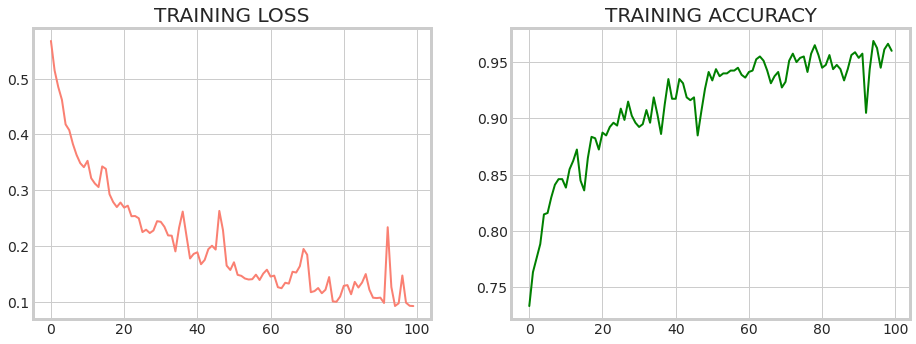

In [19]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].set_title('TRAINING LOSS');
ax[1].set_title('TRAINING ACCURACY');


ax[0].plot(history.history['loss'], color= 'salmon',lw=2);
ax[1].plot(history.history['accuracy'], color= 'green',lw=2);

In [20]:
#predict the validation data
#predictions = model.predict_classes(bf_train_val)
predictions=model.predict(bf_train_val) 
classes=np.argmax(predictions,axis=1)


In [21]:
predictions

array([[3.41385603e-04],
       [4.95201349e-03],
       [2.27987766e-04],
       [6.43793464e-05],
       [8.62061977e-04],
       [1.05732679e-03],
       [1.41680539e-02],
       [4.75630403e-01],
       [9.82770026e-02],
       [4.99841571e-03],
       [1.48159802e-01],
       [8.51660967e-04],
       [2.02877432e-01],
       [1.25765800e-04],
       [9.94100571e-01],
       [1.64036635e-06],
       [4.14586067e-03],
       [8.67557526e-03],
       [9.46862055e-09],
       [8.72937744e-05],
       [4.90696222e-01],
       [2.08547711e-03],
       [7.28280306e-01],
       [2.30792284e-05],
       [3.33327055e-03],
       [8.25047493e-04],
       [3.53995264e-02],
       [8.09520483e-04],
       [2.18892097e-03],
       [2.40836382e-01],
       [1.73717737e-04],
       [9.93892074e-01],
       [7.78600574e-03],
       [1.34529209e-05],
       [1.00201368e-02],
       [9.50536370e-01],
       [5.01263967e-05],
       [2.64295936e-03],
       [1.68263912e-04],
       [3.25119495e-03],


In [22]:
classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [23]:
print(classification_report(y_val, classes))

              precision    recall  f1-score   support

           0       0.72      1.00      0.84       145
           1       0.00      0.00      0.00        55

    accuracy                           0.73       200
   macro avg       0.36      0.50      0.42       200
weighted avg       0.53      0.72      0.61       200



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
confusion_mat = confusion_matrix(y_val, predictions)

plt.figure(figsize=(10,10))
sns.heatmap(confusion_mat, square=True, annot=True,
            yticklabels=['FIRE_IMG', 'NON_FIRE_IMG'],
            xticklabels=['FIRE_IMG', 'NON_FIRE_IMG']);
plt.title('CONFUSION MATRIX');
plt.xlabel('Y_TRUE');
plt.ylabel("PREDICTIONS");

ValueError: ignored